In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 3060'

In [3]:
df = pd.read_csv('./Form-714-csv-files-June-2021/Part 3 Schedule 2 - Planning Area Hourly Demand.csv')
respondent_id_info = pd.read_csv('./Form-714-csv-files-June-2021/Respondent IDs.csv')
good_ids = respondent_id_info['respondent_id'].unique()[3:]
df = df[df['respondent_id'].isin(good_ids)]
hour_cols = [f'hour{i:02d}' for i in range(1, 25)]
df = df.loc[~(df[hour_cols] == 0).any(axis=1)]


In [4]:
def prepare_vae_data(df):
    # Keep hourly columns as features
    hour_cols = [f'hour{i:02d}' for i in range(1, 25)]
    
    # Convert date and extract features
    df['plan_date'] = pd.to_datetime(df['plan_date'])
    df['year'] = df['plan_date'].dt.year
    df['month'] = df['plan_date'].dt.month
    df['day_of_week'] = df['plan_date'].dt.dayofweek
    
    # Cyclic encoding for temporal features
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Normalize year
    df['year'] = (df['year'] - df['year'].mean()) / df['year'].std()
    
    # Encode respondents
    df['respondent_id'] = df['respondent_id'].astype('category')
    df['respondent_idx'] = df['respondent_id'].cat.codes
    df
    # Normalize load values per respondent
    for col in hour_cols:
        df['og_' + col] = df[col].copy()
        df[col] = df.groupby('respondent_id')[col].transform(
            lambda x: (x - x.mean()) / x.std()
        )
    
    return df


In [5]:
# VAE Dataset
class VAEDataset(Dataset):
    def __init__(self, df):
        self.loads = torch.FloatTensor(df[[f'hour{i:02d}' for i in range(1, 25)]].values)
        self.respondents = torch.LongTensor(df['respondent_idx'].values)
        self.temporal = torch.FloatTensor(df[['year', 'month_sin', 'month_cos', 'day_sin', 'day_cos']].values)
        
    def __len__(self):
        return len(self.loads)
    
    def __getitem__(self, idx):
        return self.loads[idx], self.respondents[idx], self.temporal[idx]


In [6]:

# VAE Model
class VAE(nn.Module):
    def __init__(self, num_respondents, temporal_dim=5, load_dim=24, 
                 embed_dim=32, hidden_dim=512, latent_dim=64):
        super().__init__()
        
        self.embed = nn.Embedding(num_respondents, embed_dim)
        self.temporal_dim = temporal_dim
        self.load_dim = load_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(load_dim + embed_dim + temporal_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim//4, self.latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim//4, self.latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim + embed_dim + temporal_dim, hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, load_dim)
        )
    
    def encode(self, x, r, t):
        embedded = self.embed(r)
        combined = torch.cat([x, embedded, t], dim=1)
        h = self.encoder(combined)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z, r, t):
        embedded = self.embed(r)
        combined = torch.cat([z, embedded, t], dim=1)
        return self.decoder(combined)
    
    def forward(self, x, r, t):
        mu, logvar = self.encode(x, r, t)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, r, t), mu, logvar


In [7]:
# Training Function
def train_vae(df, num_epochs=50, batch_size=2**15, model=None):
    df = prepare_vae_data(df)
    dataset = VAEDataset(df)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    num_respondents = len(df['respondent_id'].cat.categories)
    if model is None:
        model = VAE(num_respondents)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('device: ', device)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for loads, respondents, temporal in loader:
            optimizer.zero_grad()
            loads = loads.to(device)
            respondents = respondents.to(device)
            temporal = temporal.to(device)
            recon, mu, logvar = model(loads, respondents, temporal)
            
            # Reconstruction loss + KL divergence
            recon_loss = nn.functional.mse_loss(recon, loads, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            loss = recon_loss + kl_div
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {train_loss/len(dataset):.4f}')
    
    return model


In [8]:
vae_model = train_vae(df, num_epochs=100)

/tmp/ipykernel_3460886/3901490636.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[col] = df.groupby('respondent_id')[col].transform(
/tmp/ipykernel_3460886/3901490636.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[col] = df.groupby('respondent_id')[col].transform(
/tmp/ipykernel_3460886/3901490636.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[col] = df.groupby('respondent_id')[col].transform(
/

device:  cuda
Epoch 1, Loss: 18.8967
Epoch 2, Loss: 9.9392
Epoch 3, Loss: 8.6032
Epoch 4, Loss: 8.2184
Epoch 5, Loss: 7.9584
Epoch 6, Loss: 7.5780
Epoch 7, Loss: 6.8239
Epoch 8, Loss: 6.0537
Epoch 9, Loss: 5.3937
Epoch 10, Loss: 4.8811
Epoch 11, Loss: 4.6108
Epoch 12, Loss: 4.5334
Epoch 13, Loss: 4.4155
Epoch 14, Loss: 4.3553
Epoch 15, Loss: 4.2921
Epoch 16, Loss: 4.2306
Epoch 17, Loss: 4.1931
Epoch 18, Loss: 4.0971
Epoch 19, Loss: 4.0682
Epoch 20, Loss: 4.0083
Epoch 21, Loss: 3.9803
Epoch 22, Loss: 3.9234
Epoch 23, Loss: 3.8606
Epoch 24, Loss: 3.8211
Epoch 25, Loss: 3.7880
Epoch 26, Loss: 3.7941
Epoch 27, Loss: 3.7413
Epoch 28, Loss: 3.7151
Epoch 29, Loss: 3.7024
Epoch 30, Loss: 3.8173
Epoch 31, Loss: 3.7058
Epoch 32, Loss: 3.6409
Epoch 33, Loss: 3.6066
Epoch 34, Loss: 3.5766
Epoch 35, Loss: 3.5555
Epoch 36, Loss: 3.5361
Epoch 37, Loss: 3.5305
Epoch 38, Loss: 3.5193
Epoch 39, Loss: 3.4958
Epoch 40, Loss: 3.5166
Epoch 41, Loss: 3.4609
Epoch 42, Loss: 3.4569
Epoch 43, Loss: 3.4280
Epoch

In [9]:
torch.save(vae_model.state_dict(), 'load_vae_model.pth')

In [10]:
# vae_model = VAE(num_respondents=len(df['respondent_id'].cat.categories))
# vae_model.load_state_dict(torch.load('load_vae_model.pth'))

In [26]:
# Generation and Visualization
def generate_and_compare(model, df, respondent_id, date, n_samples=10):
    # Prepare input
    respondent_data = df[df['respondent_id'] == respondent_id]
    sample = respondent_data[respondent_data['plan_date'] == date].iloc[0]
    
    with torch.no_grad():
        # Get original data
        original = torch.FloatTensor(sample[[f'hour{i:02d}' for i in range(1, 25)]]).unsqueeze(0)
        respondent = torch.LongTensor([sample['respondent_idx']])
        temporal = torch.FloatTensor(sample[['year', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]).unsqueeze(0)
        model.to('cpu')
        
        # Reconstruct
        recon, _, _ = model(original, respondent, temporal)
        
        # Generate new samples
        
        z = torch.randn(n_samples, model.latent_dim)  # Generate 5 samples
        
        r = respondent.repeat(n_samples)
        t = temporal.repeat(n_samples, 1)
        generated = model.decode(z, r, t)
    
    # Denormalize
    mean = respondent_data[[f'og_hour{i:02d}' for i in range(1, 25)]].mean().values # .mean()
    std = respondent_data[[f'og_hour{i:02d}' for i in range(1, 25)]].std().values #.mean()
    
    original = original.squeeze().numpy() * std + mean
    recon = recon.squeeze().numpy() * std + mean
    generated = generated.numpy() * std + mean
    
    # Plot
    hours = np.arange(24)
    plt.figure(figsize=(12, 6))
    plt.plot(hours, original, label='Original', linewidth=4, color='r', zorder=100)
    plt.plot(hours, recon, '--', label='Reconstruction', linewidth=3, color='r', zorder=99)
    for i, gen in enumerate(generated):
        plt.plot(hours, gen, alpha=0.75, color='k', linewidth=2)# label=f'Generated Sample {i+1}')
    
    a_date = sample['plan_date']
    a_year = a_date.year
    year_buff = 2
    a_doy = a_date.day_of_year
    day_buff = 5
    a_bool = np.logical_and(
        np.abs(respondent_data['plan_date'].dt.year - a_year) <= year_buff,
        np.abs(respondent_data['plan_date'].dt.day_of_year - a_doy) <= day_buff)
    random_dates = np.random.choice(respondent_data['plan_date'].loc[a_bool], n_samples, replace=False)
    for a_date in random_dates:
        random_sample = respondent_data.loc[respondent_data['plan_date']==a_date]
        random_sample = random_sample[[f'og_hour{i:02d}' for i in range(1, 25)]].values[0]
        plt.plot(hours, random_sample, label=str(a_date)[:10], alpha=0.75, linewidth=2)
    
    for i, gen in enumerate(generated):
        plt.plot(hours, gen, alpha=1.0, color='k', linewidth=2)# label=f'Generated Sample {i+1}')
    plt.title(f'Load Pattern for Respondent {respondent_id} on {date}')
    plt.xlabel('Hour')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True)
    plt.show()


2013-07-24
266


/tmp/ipykernel_3460886/887600431.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  original = torch.FloatTensor(sample[[f'hour{i:02d}' for i in range(1, 25)]]).unsqueeze(0)
/tmp/ipykernel_3460886/887600431.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temporal = torch.FloatTensor(sample[['year', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]).unsqueeze(0)


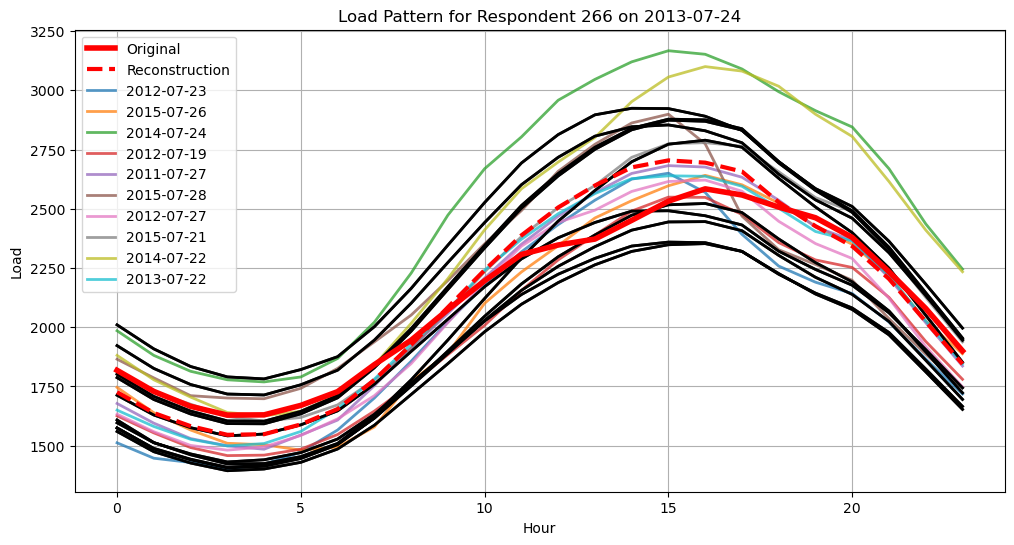

In [27]:
# respondent_id = np.random.choice(df['respondent_id'])
respondent_id = 266
respondent_data = df.loc[df['respondent_id']==respondent_id]
date = str(np.random.choice(respondent_data['plan_date']))[:10]
print(date)
print(respondent_id)

generate_and_compare(vae_model, df, 
                    respondent_id=respondent_id,  # Example respondent ID
                    date=date)   # Example date